In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
class VehicleSensorDataGenerator:
    """Generate synthetic vehicle sensor data with realistic anomalies"""
    
    def __init__(self):
        self.feature_names = [
            'speed', 'engine_temp', 'rpm', 'oil_pressure', 
            'vibration', 'throttle_position', 'fuel_pressure',
            'coolant_temp', 'air_intake_temp', 'battery_voltage',
            'acceleration', 'brake_pressure', 'transmission_temp',
            'exhaust_temp', 'oxygen_sensor'
        ]
        
        # Normal operating ranges
        self.normal_ranges = {
            'speed': (50, 110),              # km/h
            'engine_temp': (85, 95),         # °C
            'rpm': (1500, 3500),             # RPM
            'oil_pressure': (25, 40),        # PSI
            'vibration': (0.05, 0.25),       # g-force
            'throttle_position': (10, 80),   # %
            'fuel_pressure': (40, 60),       # PSI
            'coolant_temp': (80, 95),        # °C
            'air_intake_temp': (20, 50),     # °C
            'battery_voltage': (12.5, 14.5), # V
            'acceleration': (-0.5, 2.5),     # m/s²
            'brake_pressure': (0, 30),       # PSI
            'transmission_temp': (70, 95),   # °C
            'exhaust_temp': (300, 500),      # °C
            'oxygen_sensor': (0.1, 0.9)      # V
        }
    
    def generate_normal_sample(self):
        """Generate a single normal operating sample with feature correlations"""
        sample = {}
        
        # Base features
        sample['speed'] = np.random.uniform(50, 110)
        sample['throttle_position'] = np.random.uniform(10, 80)
        
        # Speed and throttle correlated features
        speed_factor = (sample['speed'] - 50) / 60
        throttle_factor = sample['throttle_position'] / 100
        
        sample['rpm'] = 1500 + (speed_factor * 2000) + np.random.normal(0, 100)
        sample['acceleration'] = throttle_factor * 2.5 - 0.5 + np.random.normal(0, 0.2)
        
        # Engine temperature with some correlation to RPM
        rpm_factor = (sample['rpm'] - 1500) / 2000
        sample['engine_temp'] = 85 + (rpm_factor * 10) + np.random.normal(0, 2)
        sample['coolant_temp'] = sample['engine_temp'] - np.random.uniform(5, 10)
        sample['transmission_temp'] = 70 + (rpm_factor * 25) + np.random.normal(0, 3)
        
        # Oil pressure inversely related to temperature (slight)
        temp_factor = (sample['engine_temp'] - 85) / 10
        sample['oil_pressure'] = 32.5 - (temp_factor * 2) + np.random.normal(0, 1.5)
        
        # Vibration increases with RPM
        sample['vibration'] = 0.1 + (rpm_factor * 0.15) + np.random.normal(0, 0.02)
        
        # Fuel system
        sample['fuel_pressure'] = np.random.uniform(40, 60)
        
        # Temperature sensors
        sample['air_intake_temp'] = 20 + (speed_factor * 30) + np.random.normal(0, 3)
        sample['exhaust_temp'] = 300 + (rpm_factor * 200) + np.random.normal(0, 20)
        
        # Electrical
        sample['battery_voltage'] = np.random.uniform(12.5, 14.5)
        sample['oxygen_sensor'] = np.random.uniform(0.1, 0.9)
        
        # Braking
        if np.random.random() < 0.3:  # 30% chance of braking
            sample['brake_pressure'] = np.random.uniform(10, 30)
            sample['acceleration'] = np.random.uniform(-0.5, 0)
        else:
            sample['brake_pressure'] = np.random.uniform(0, 5)
        
        return sample
    
    def generate_anomaly_sample(self):
        """Generate anomalous samples with complex failure patterns"""
        sample = self.generate_normal_sample()
        anomaly_type = np.random.choice([
            'overheating', 'low_oil_pressure', 'high_vibration',
            'engine_misfire', 'fuel_system', 'electrical', 
            'sensor_degradation', 'multiple_cascade', 'transmission_failure'
        ])
        
        if anomaly_type == 'overheating':
            # Overheating cascades through multiple systems
            temp_increase = np.random.uniform(15, 30)
            sample['engine_temp'] += temp_increase
            sample['coolant_temp'] += temp_increase * 0.8
            sample['transmission_temp'] += temp_increase * 0.6
            sample['exhaust_temp'] += np.random.uniform(100, 200)
            sample['oil_pressure'] *= np.random.uniform(0.6, 0.8)
            sample['vibration'] *= np.random.uniform(1.5, 2.0)
            
        elif anomaly_type == 'low_oil_pressure':
            sample['oil_pressure'] = np.random.uniform(5, 18)
            sample['vibration'] *= np.random.uniform(2.0, 3.0)
            sample['engine_temp'] += np.random.uniform(8, 20)
            sample['rpm'] *= np.random.uniform(1.1, 1.3)
            
        elif anomaly_type == 'high_vibration':
            sample['vibration'] = np.random.uniform(0.5, 1.2)
            sample['rpm'] += np.random.uniform(-500, 800)
            sample['engine_temp'] += np.random.uniform(5, 15)
            sample['oil_pressure'] *= np.random.uniform(0.8, 0.95)
            
        elif anomaly_type == 'engine_misfire':
            sample['rpm'] = np.random.uniform(800, 1400)
            sample['vibration'] *= np.random.uniform(2.5, 4.0)
            sample['throttle_position'] *= np.random.uniform(0.5, 0.7)
            sample['oxygen_sensor'] = np.random.uniform(0.05, 0.3)
            sample['exhaust_temp'] *= np.random.uniform(0.7, 0.85)
            
        elif anomaly_type == 'fuel_system':
            sample['fuel_pressure'] = np.random.uniform(15, 35)
            sample['throttle_position'] *= np.random.uniform(0.6, 1.4)
            sample['rpm'] *= np.random.uniform(0.7, 0.9)
            sample['oxygen_sensor'] *= np.random.uniform(0.5, 0.8)
            sample['acceleration'] *= 0.6
            
        elif anomaly_type == 'electrical':
            sample['battery_voltage'] = np.random.uniform(10.0, 12.0)
            sample['oxygen_sensor'] *= np.random.uniform(0.6, 0.9)
            if np.random.random() < 0.5:
                # Sensor malfunction
                sample['air_intake_temp'] = np.random.uniform(-10, 10)
            
        elif anomaly_type == 'sensor_degradation':
            # Multiple sensors giving unreliable readings
            sensor_list = ['oxygen_sensor', 'air_intake_temp', 'battery_voltage']
            for sensor in np.random.choice(sensor_list, size=2, replace=False):
                if sensor == 'oxygen_sensor':
                    sample[sensor] = np.random.uniform(0, 0.1)
                elif sensor == 'air_intake_temp':
                    sample[sensor] = np.random.uniform(-20, 5)
                elif sensor == 'battery_voltage':
                    sample[sensor] = np.random.uniform(11, 12)
                    
        elif anomaly_type == 'transmission_failure':
            sample['transmission_temp'] = np.random.uniform(105, 130)
            sample['rpm'] += np.random.uniform(-300, 600)
            sample['vibration'] *= np.random.uniform(1.8, 2.5)
            sample['oil_pressure'] *= np.random.uniform(0.85, 0.95)
            
        elif anomaly_type == 'multiple_cascade':
            # Catastrophic multiple system failure
            sample['engine_temp'] = np.random.uniform(105, 125)
            sample['oil_pressure'] = np.random.uniform(8, 18)
            sample['vibration'] *= np.random.uniform(2.5, 3.5)
            sample['battery_voltage'] *= np.random.uniform(0.80, 0.90)
            sample['fuel_pressure'] *= np.random.uniform(0.6, 0.8)
            sample['transmission_temp'] += np.random.uniform(15, 30)
        
        return sample
    
    def generate_dataset(self, n_samples=10000, anomaly_ratio=0.05):
        """Generate complete dataset with temporal patterns"""
        n_anomalies = int(n_samples * anomaly_ratio)
        n_normal = n_samples - n_anomalies
        
        print(f"Generating {n_samples} samples...")
        print(f"  - Normal samples: {n_normal}")
        print(f"  - Anomalous samples: {n_anomalies}")
        
        data = []
        labels = []
        
        # Generate normal samples with temporal variation
        for i in range(n_normal):
            data.append(self.generate_normal_sample())
            labels.append(0)
            
        # Generate anomalous samples
        for i in range(n_anomalies):
            data.append(self.generate_anomaly_sample())
            labels.append(1)
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        df['label'] = labels
        
        # Shuffle
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        return df

In [4]:
class DeepVariationalAutoencoder:
    """
    Deep Variational Autoencoder with complex architecture
    Uses probabilistic approach for robust anomaly detection
    """
    
    def __init__(self, input_dim, latent_dim=8):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.scaler = RobustScaler()
        self.model = None
        self.encoder = None
        self.decoder = None
        self.history = None
        self.threshold = None
        self.reconstruction_threshold = None
        self.kl_threshold = None
        
    def sampling(self, args):
        """Reparameterization trick for VAE"""
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def build_deep_vae(self):
        """Build deep VAE with complex architecture"""
        
        # ==================== ENCODER ====================
        encoder_input = layers.Input(shape=(self.input_dim,), name='encoder_input')
        
        # First encoding block
        x = layers.Dense(128, name='enc_dense_1')(encoder_input)
        x = layers.BatchNormalization(name='enc_bn_1')(x)
        x = layers.LeakyReLU(alpha=0.2, name='enc_lrelu_1')(x)
        x = layers.Dropout(0.3, name='enc_dropout_1')(x)
        
        # Second encoding block
        x = layers.Dense(64, name='enc_dense_2')(x)
        x = layers.BatchNormalization(name='enc_bn_2')(x)
        x = layers.LeakyReLU(alpha=0.2, name='enc_lrelu_2')(x)
        x = layers.Dropout(0.3, name='enc_dropout_2')(x)
        
        # Third encoding block
        x = layers.Dense(32, name='enc_dense_3')(x)
        x = layers.BatchNormalization(name='enc_bn_3')(x)
        x = layers.LeakyReLU(alpha=0.2, name='enc_lrelu_3')(x)
        x = layers.Dropout(0.2, name='enc_dropout_3')(x)
        
        # Fourth encoding block
        x = layers.Dense(16, name='enc_dense_4')(x)
        x = layers.BatchNormalization(name='enc_bn_4')(x)
        x = layers.LeakyReLU(alpha=0.2, name='enc_lrelu_4')(x)
        
        # Latent space parameters
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        
        # Sampling layer
        z = layers.Lambda(self.sampling, name='z')([z_mean, z_log_var])
        
        # Build encoder model
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
        
        # ==================== DECODER ====================
        decoder_input = layers.Input(shape=(self.latent_dim,), name='decoder_input')
        
        # First decoding block
        x = layers.Dense(16, name='dec_dense_1')(decoder_input)
        x = layers.BatchNormalization(name='dec_bn_1')(x)
        x = layers.LeakyReLU(alpha=0.2, name='dec_lrelu_1')(x)
        
        # Second decoding block
        x = layers.Dense(32, name='dec_dense_2')(x)
        x = layers.BatchNormalization(name='dec_bn_2')(x)
        x = layers.LeakyReLU(alpha=0.2, name='dec_lrelu_2')(x)
        x = layers.Dropout(0.2, name='dec_dropout_2')(x)
        
        # Third decoding block
        x = layers.Dense(64, name='dec_dense_3')(x)
        x = layers.BatchNormalization(name='dec_bn_3')(x)
        x = layers.LeakyReLU(alpha=0.2, name='dec_lrelu_3')(x)
        x = layers.Dropout(0.3, name='dec_dropout_3')(x)
        
        # Fourth decoding block
        x = layers.Dense(128, name='dec_dense_4')(x)
        x = layers.BatchNormalization(name='dec_bn_4')(x)
        x = layers.LeakyReLU(alpha=0.2, name='dec_lrelu_4')(x)
        x = layers.Dropout(0.3, name='dec_dropout_4')(x)
        
        # Output layer
        decoder_output = layers.Dense(self.input_dim, activation='linear', name='decoder_output')(x)
        
        # Build decoder model
        self.decoder = Model(decoder_input, decoder_output, name='decoder')
        
        # ==================== FULL VAE MODEL ====================
        # Create a custom VAE model that computes the loss internally
        class VAEModel(Model):
            def __init__(self, encoder, decoder, kl_weight=0.001, **kwargs):
                super().__init__(**kwargs)
                self.encoder = encoder
                self.decoder = decoder
                self.kl_weight = kl_weight
                self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
                self.reconstruction_loss_tracker = keras.metrics.Mean(name="recon_loss")
                self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
            
            def get_config(self):
                return {
                    "kl_weight": self.kl_weight,
                }
            
            @property
            def metrics(self):
                return [
                    self.total_loss_tracker,
                    self.reconstruction_loss_tracker,
                    self.kl_loss_tracker,
                ]
            
            def call(self, inputs):
                z_mean, z_log_var, z = self.encoder(inputs)
                reconstruction = self.decoder(z)
                return reconstruction
            
            def train_step(self, data):
                # Handle both single input and (input, target) tuple
                if isinstance(data, tuple):
                    data = data[0]  # For autoencoders, input and target are the same
                
                with tf.GradientTape() as tape:
                    # Forward pass
                    z_mean, z_log_var, z = self.encoder(data)
                    reconstruction = self.decoder(z)
                    
                    # Compute reconstruction loss
                    reconstruction_loss = tf.reduce_mean(
                        tf.reduce_sum(
                            tf.square(data - reconstruction), 
                            axis=1
                        )
                    )
                    
                    # Compute KL divergence
                    kl_loss = -0.5 * tf.reduce_mean(
                        tf.reduce_sum(
                            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                            axis=1
                        )
                    )
                    
                    # Total loss
                    total_loss = reconstruction_loss + self.kl_weight * kl_loss
                
                # Compute gradients
                grads = tape.gradient(total_loss, self.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
                # Update metrics
                self.total_loss_tracker.update_state(total_loss)
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
                self.kl_loss_tracker.update_state(kl_loss)
                
                return {
                    "loss": self.total_loss_tracker.result(),
                    "recon_loss": self.reconstruction_loss_tracker.result(),
                    "kl_loss": self.kl_loss_tracker.result(),
                }
            
            def test_step(self, data):
                # Handle both single input and (input, target) tuple
                if isinstance(data, tuple):
                    data = data[0]  # For autoencoders, input and target are the same
                
                # Forward pass
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                
                # Compute losses
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.square(data - reconstruction), 
                        axis=1
                    )
                )
                
                kl_loss = -0.5 * tf.reduce_mean(
                    tf.reduce_sum(
                        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                        axis=1
                    )
                )
                
                total_loss = reconstruction_loss + self.kl_weight * kl_loss
                
                # Update metrics
                self.total_loss_tracker.update_state(total_loss)
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
                self.kl_loss_tracker.update_state(kl_loss)
                
                return {
                    "loss": self.total_loss_tracker.result(),
                    "recon_loss": self.reconstruction_loss_tracker.result(),
                    "kl_loss": self.kl_loss_tracker.result(),
                }
        
        # Create VAE model
        self.model = VAEModel(self.encoder, self.decoder, kl_weight=0.001, name='deep_vae')
        
        return self.model
    
    def train(self, X_train, X_val, epochs=150, batch_size=64):
        """Train the deep VAE"""
        print("\n" + "="*60)
        print("TRAINING DEEP VARIATIONAL AUTOENCODER")
        print("="*60)
        
        # Scale the data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        
        # Build model
        self.build_deep_vae()

        # Compile with fixed learning rate (will be adjusted by ReduceLROnPlateau)
        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        self.model.compile(optimizer=optimizer)

        # Build the model by passing a sample through it, then show summary
        print("\nModel Architecture:")
        sample_input = X_train_scaled[:1]  # Use first sample to build the model
        _ = self.model(sample_input)
        self.model.summary()
                # Callbacks
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
        
        # Train
        print(f"\nTraining on {X_train_scaled.shape[0]} samples...")
        print(f"Validation on {X_val_scaled.shape[0]} samples...")
        
        self.history = self.model.fit(
            X_train_scaled,
            X_train_scaled,
            validation_data=(X_val_scaled, X_val_scaled),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        
        print("\nTraining completed!")
        return self.history
    
    def calculate_reconstruction_error(self, X):
        """Calculate reconstruction error"""
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled, verbose=0)
        mse = np.mean(np.square(X_scaled - predictions), axis=1)
        return mse
    
    def calculate_kl_divergence(self, X):
        """Calculate KL divergence for samples"""
        X_scaled = self.scaler.transform(X)
        z_mean, z_log_var, _ = self.encoder.predict(X_scaled, verbose=0)
        kl_div = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)
        return kl_div
    
    def calculate_anomaly_score(self, X):
        """Calculate combined anomaly score"""
        recon_error = self.calculate_reconstruction_error(X)
        kl_div = self.calculate_kl_divergence(X)
        
        # Normalize both scores
        recon_normalized = (recon_error - np.mean(recon_error)) / (np.std(recon_error) + 1e-8)
        kl_normalized = (kl_div - np.mean(kl_div)) / (np.std(kl_div) + 1e-8)
        
        # Combined score
        anomaly_score = 0.7 * recon_normalized + 0.3 * kl_normalized
        
        return anomaly_score, recon_error, kl_div
    
    def set_threshold(self, X_train, percentile=95):
        """Set anomaly threshold based on training data"""
        anomaly_scores, recon_errors, kl_divs = self.calculate_anomaly_score(X_train)
        
        self.threshold = np.percentile(anomaly_scores, percentile)
        self.reconstruction_threshold = np.percentile(recon_errors, percentile)
        self.kl_threshold = np.percentile(kl_divs, percentile)
        
        print(f"\n{'='*60}")
        print("THRESHOLD SETTINGS")
        print(f"{'='*60}")
        print(f"Combined anomaly threshold ({percentile}th percentile): {self.threshold:.6f}")
        print(f"Reconstruction threshold: {self.reconstruction_threshold:.6f}")
        print(f"KL divergence threshold: {self.kl_threshold:.6f}")
        
        return self.threshold
    
    def predict(self, X):
        """Predict anomalies using combined score"""
        anomaly_scores, recon_errors, kl_divs = self.calculate_anomaly_score(X)
        predictions = (anomaly_scores > self.threshold).astype(int)
        
        return predictions, anomaly_scores, recon_errors, kl_divs
    
    def get_latent_representation(self, X):
        """Get latent space representation"""
        X_scaled = self.scaler.transform(X)
        z_mean, z_log_var, z = self.encoder.predict(X_scaled, verbose=0)
        return z_mean, z_log_var, z
    
def evaluate_model(y_true, y_pred, anomaly_scores):
    """Comprehensive model evaluation"""
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['Normal', 'Anomaly'],
                                digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"                Normal  Anomaly")
    print(f"Actual Normal   {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"       Anomaly  {cm[1,0]:6d}  {cm[1,1]:6d}")
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nDetailed Metrics:")
    print(f"  Accuracy:    {accuracy:.4f}")
    print(f"  Precision:   {precision:.4f}")
    print(f"  Recall:      {recall:.4f}")
    print(f"  F1-Score:    {f1:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    
    # ROC AUC
    roc_auc = roc_auc_score(y_true, anomaly_scores)
    print(f"  ROC AUC:     {roc_auc:.4f}")
    
    return roc_auc


def plot_comprehensive_results(vae, history, X_test, y_test, predictions, anomaly_scores, recon_errors, kl_divs):
    """Create comprehensive visualization"""
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Training History - Total Loss
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Total Loss', fontsize=10)
    ax1.set_title('Training History - Total Loss', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Reconstruction Loss
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history.history['recon_loss'], label='Training Recon Loss', linewidth=2)
    ax2.plot(history.history['val_recon_loss'], label='Validation Recon Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Reconstruction Loss', fontsize=10)
    ax2.set_title('Reconstruction Loss', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. KL Divergence Loss
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(history.history['kl_loss'], label='Training KL Loss', linewidth=2)
    ax3.plot(history.history['val_kl_loss'], label='Validation KL Loss', linewidth=2)
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.set_ylabel('KL Divergence', fontsize=10)
    ax3.set_title('KL Divergence Loss', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Anomaly Score Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    normal_scores = anomaly_scores[y_test == 0]
    anomaly_scores_pos = anomaly_scores[y_test == 1]
    
    ax4.hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    ax4.hist(anomaly_scores_pos, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
    ax4.axvline(vae.threshold, color='green', linestyle='--', linewidth=2, label='Threshold')
    ax4.set_xlabel('Anomaly Score', fontsize=10)
    ax4.set_ylabel('Density', fontsize=10)
    ax4.set_title('Anomaly Score Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Reconstruction Error Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    normal_recon = recon_errors[y_test == 0]
    anomaly_recon = recon_errors[y_test == 1]
    
    ax5.hist(normal_recon, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    ax5.hist(anomaly_recon, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
    ax5.axvline(vae.reconstruction_threshold, color='green', linestyle='--', linewidth=2, label='Threshold')
    ax5.set_xlabel('Reconstruction Error', fontsize=10)
    ax5.set_ylabel('Density', fontsize=10)
    ax5.set_title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. KL Divergence Distribution
    ax6 = fig.add_subplot(gs[1, 2])
    normal_kl = kl_divs[y_test == 0]
    anomaly_kl = kl_divs[y_test == 1]
    
    ax6.hist(normal_kl, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    ax6.hist(anomaly_kl, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
    ax6.axvline(vae.kl_threshold, color='green', linestyle='--', linewidth=2, label='Threshold')
    ax6.set_xlabel('KL Divergence', fontsize=10)
    ax6.set_ylabel('Density', fontsize=10)
    ax6.set_title('KL Divergence Distribution', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. ROC Curve
    ax7 = fig.add_subplot(gs[2, 0])
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    roc_auc = roc_auc_score(y_test, anomaly_scores)
    
    ax7.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
    ax7.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax7.set_xlabel('False Positive Rate', fontsize=10)
    ax7.set_ylabel('True Positive Rate', fontsize=10)
    ax7.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Precision-Recall Curve
    ax8 = fig.add_subplot(gs[2, 1])
    precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
    
    ax8.plot(recall, precision, linewidth=2, color='purple')
    ax8.set_xlabel('Recall', fontsize=10)
    ax8.set_ylabel('Precision', fontsize=10)
    ax8.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # 9. Confusion Matrix
    ax9 = fig.add_subplot(gs[2, 2])
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax9, 
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                cbar_kws={'label': 'Count'})
    ax9.set_xlabel('Predicted Label', fontsize=10)
    ax9.set_ylabel('True Label', fontsize=10)
    ax9.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    
    plt.suptitle('Deep Variational Autoencoder - Comprehensive Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('deep_vae_comprehensive_results.png', dpi=300, bbox_inches='tight')
    print("\nComprehensive results saved to 'deep_vae_comprehensive_results.png'")
    plt.show()


def plot_latent_space(vae, X_test, y_test):
    """Visualize latent space representation"""
    z_mean, z_log_var, z = vae.get_latent_representation(X_test)
    
    if vae.latent_dim >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot first two dimensions
        axes[0].scatter(z_mean[y_test==0, 0], z_mean[y_test==0, 1], 
                       c='blue', alpha=0.5, s=20, label='Normal')
        axes[0].scatter(z_mean[y_test==1, 0], z_mean[y_test==1, 1], 
                       c='red', alpha=0.7, s=30, label='Anomaly', marker='x')
        axes[0].set_xlabel('Latent Dimension 1', fontsize=12)
        axes[0].set_ylabel('Latent Dimension 2', fontsize=12)
        axes[0].set_title('Latent Space (Mean)', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot variance
        axes[1].scatter(z_log_var[y_test==0, 0], z_log_var[y_test==0, 1], 
                       c='blue', alpha=0.5, s=20, label='Normal')
        axes[1].scatter(z_log_var[y_test==1, 0], z_log_var[y_test==1, 1], 
                       c='red', alpha=0.7, s=30, label='Anomaly', marker='x')
        axes[1].set_xlabel('Latent Dimension 1 (log var)', fontsize=12)
        axes[1].set_ylabel('Latent Dimension 2 (log var)', fontsize=12)
        axes[1].set_title('Latent Space (Log Variance)', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('latent_space_visualization.png', dpi=300, bbox_inches='tight')
        print("Latent space visualization saved to 'latent_space_visualization.png'")
        plt.show()

In [5]:
# 1. Generate synthetic data
print("\n" + "="*60)
print("STEP 1: DATA GENERATION")
print("="*60)
    
generator = VehicleSensorDataGenerator()
df = generator.generate_dataset(n_samples=12000, anomaly_ratio=0.05)
df.to_csv("data/vehicle_sensor_data.csv", index=False)

print("Dataset saved as vehicle_sensor_data.csv")


STEP 1: DATA GENERATION
Generating 12000 samples...
  - Normal samples: 11400
  - Anomalous samples: 600
Dataset saved as vehicle_sensor_data.csv


In [6]:
print(f"\nDataset shape: {df.shape}")
print(f"\nFeatures: {', '.join(generator.feature_names)}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nAnomaly ratio: {df['label'].sum() / len(df) * 100:.2f}%")
    
print("\nDataset statistics:")
print(df.describe().round(2))


Dataset shape: (12000, 16)

Features: speed, engine_temp, rpm, oil_pressure, vibration, throttle_position, fuel_pressure, coolant_temp, air_intake_temp, battery_voltage, acceleration, brake_pressure, transmission_temp, exhaust_temp, oxygen_sensor

Class distribution:
label
0    11400
1      600
Name: count, dtype: int64

Anomaly ratio: 5.00%

Dataset statistics:
          speed  throttle_position       rpm  acceleration  engine_temp  \
count  12000.00           12000.00  12000.00      12000.00     12000.00   
mean      79.87              45.02   2486.86          0.37        90.38   
std       17.36              20.29    598.42          0.61         4.54   
min       50.00               5.99    810.14         -0.82        77.19   
25%       64.85              27.57   1984.48         -0.17        87.41   
50%       79.57              44.84   2478.73          0.26        90.06   
75%       94.85              62.57   2990.49          0.88        92.84   
max      109.99              98.33

In [7]:
print("\n" + "="*60)
print("STEP 2: DATA PREPARATION")
print("="*60)
    
X = df.drop('label', axis=1).values
y = df['label'].values
    
    # Split: 70% train (normal only), 15% validation, 15% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.176, random_state=42, stratify=y_train_full
    )
    
    # Use only normal samples for training (unsupervised)
X_train_normal = X_train[y_train == 0]
    
print(f"\nData split:")
print(f"  Training (normal only): {X_train_normal.shape[0]:5d} samples")
print(f"  Validation:             {X_val.shape[0]:5d} samples (Normal: {(y_val==0).sum()}, Anomaly: {(y_val==1).sum()})")
print(f"  Test:                   {X_test.shape[0]:5d} samples (Normal: {(y_test==0).sum()}, Anomaly: {(y_test==1).sum()})")


STEP 2: DATA PREPARATION

Data split:
  Training (normal only):  7984 samples
  Validation:              1796 samples (Normal: 1706, Anomaly: 90)
  Test:                    1800 samples (Normal: 1710, Anomaly: 90)


In [8]:
print("\n" + "="*60)
print("STEP 3: MODEL TRAINING")
print("="*60)
    
vae = DeepVariationalAutoencoder(input_dim=X.shape[1], latent_dim=8)
history = vae.train(
        X_train_normal, 
        X_val,
        epochs=150,
        batch_size=64
    )


STEP 3: MODEL TRAINING

TRAINING DEEP VARIATIONAL AUTOENCODER


Model Architecture:
Model: "deep_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 8),               14144     
                              (None, 8),                         
                              (None, 8)]                         
                                                                 
 decoder (Functional)        (None, 15)                14015     
                                                                 
Total params: 28165 (110.02 KB)
Trainable params: 27199 (106.25 KB)
Non-trainable params: 966 (3.77 KB)
_________________________________________________________________

Training on 7984 samples...
Validation on 1796 samples...
Epoch 1/150
125/125 [==============================] - 2s 4ms/step - loss: 4.5413 - recon_loss: 3.2409 - kl_loss: 27.6775 - val_loss: 3.4431

In [9]:
print("\n" + "="*60)
print("STEP 4: THRESHOLD CALIBRATION")
print("="*60)
    
vae.set_threshold(X_train_normal, percentile=95)
print("\n" + "="*60)
print("STEP 5: MODEL EVALUATION")
print("="*60)
vae.threshold = 0.5    # or any value appropriate for your scores

predictions, anomaly_scores, recon_errors, kl_divs = vae.predict(X_test)
roc_auc = evaluate_model(y_test, predictions, anomaly_scores)


STEP 4: THRESHOLD CALIBRATION

THRESHOLD SETTINGS
Combined anomaly threshold (95th percentile): 1.403098
Reconstruction threshold: 0.036173
KL divergence threshold: 43.210623

STEP 5: MODEL EVALUATION

MODEL EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9861    0.9971    0.9916      1710
     Anomaly     0.9296    0.7333    0.8199        90

    accuracy                         0.9839      1800
   macro avg     0.9578    0.8652    0.9057      1800
weighted avg     0.9833    0.9839    0.9830      1800


Confusion Matrix:
                Predicted
                Normal  Anomaly
Actual Normal     1705       5
       Anomaly      24      66

Detailed Metrics:
  Accuracy:    0.9839
  Precision:   0.9296
  Recall:      0.7333
  F1-Score:    0.8199
  Specificity: 0.9971
  ROC AUC:     0.9165



STEP 6: GENERATING VISUALIZATIONS

Comprehensive results saved to 'deep_vae_comprehensive_results.png'


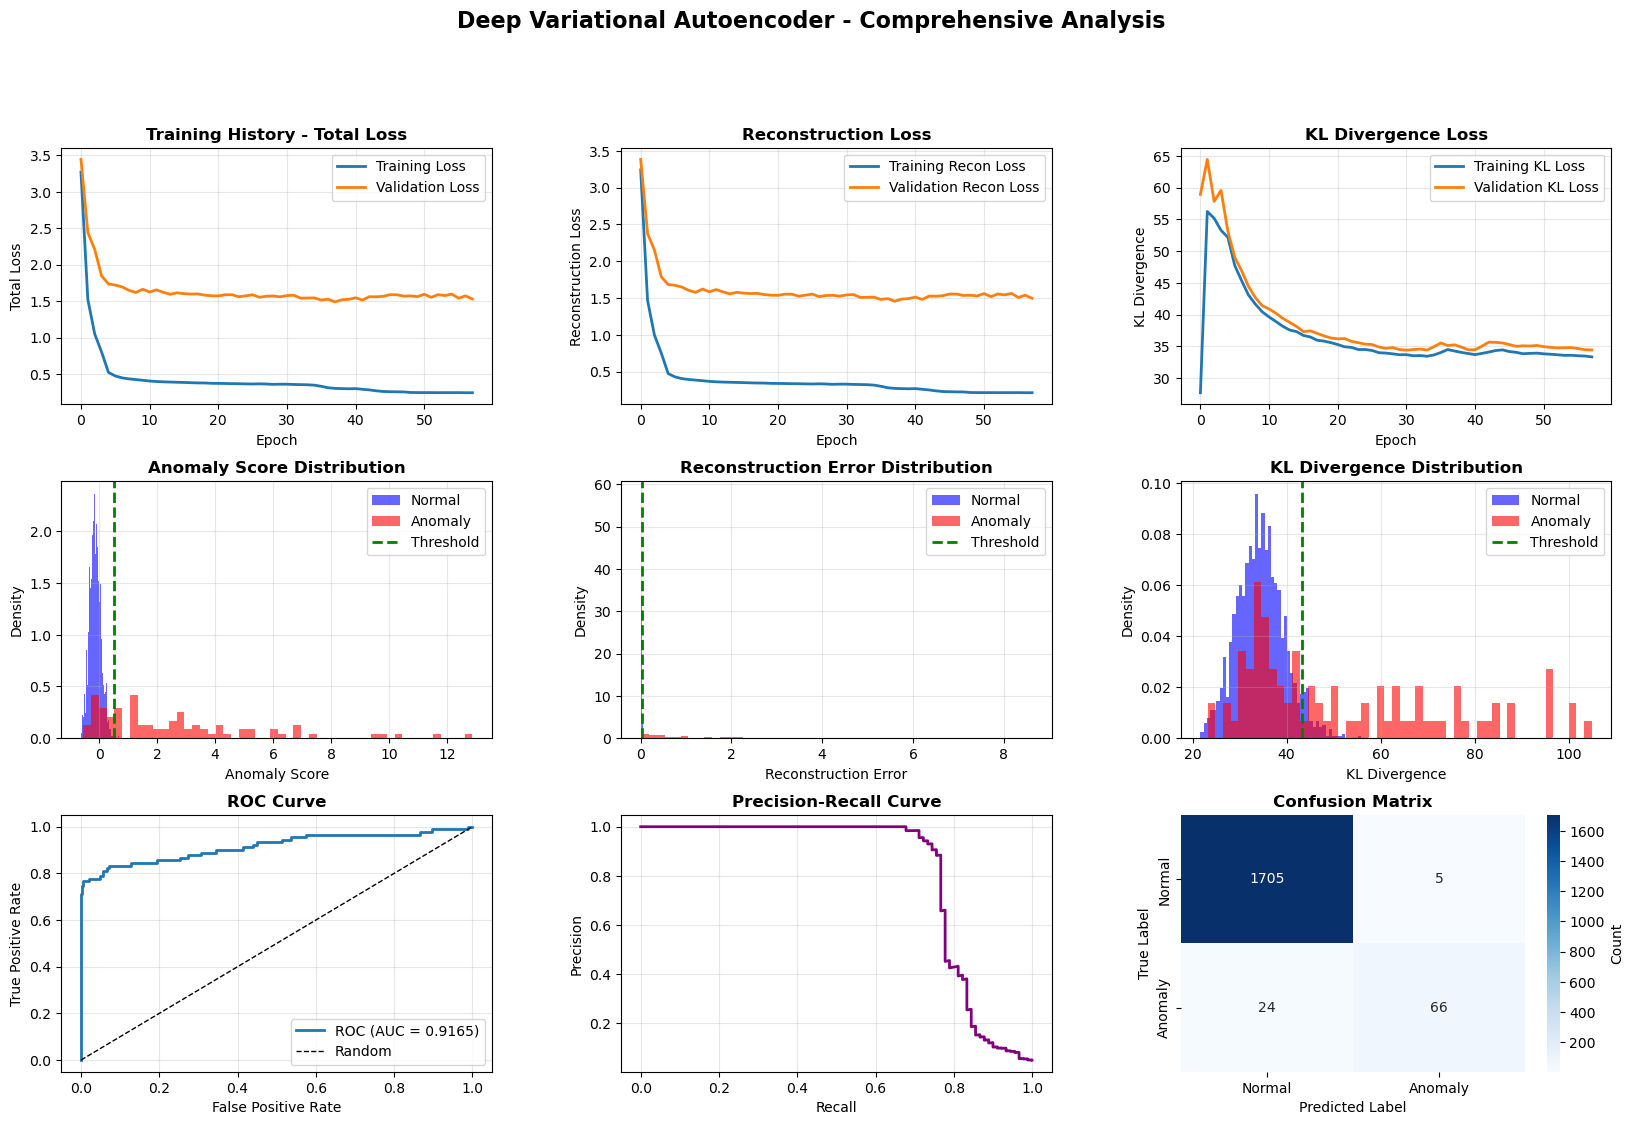

Latent space visualization saved to 'latent_space_visualization.png'


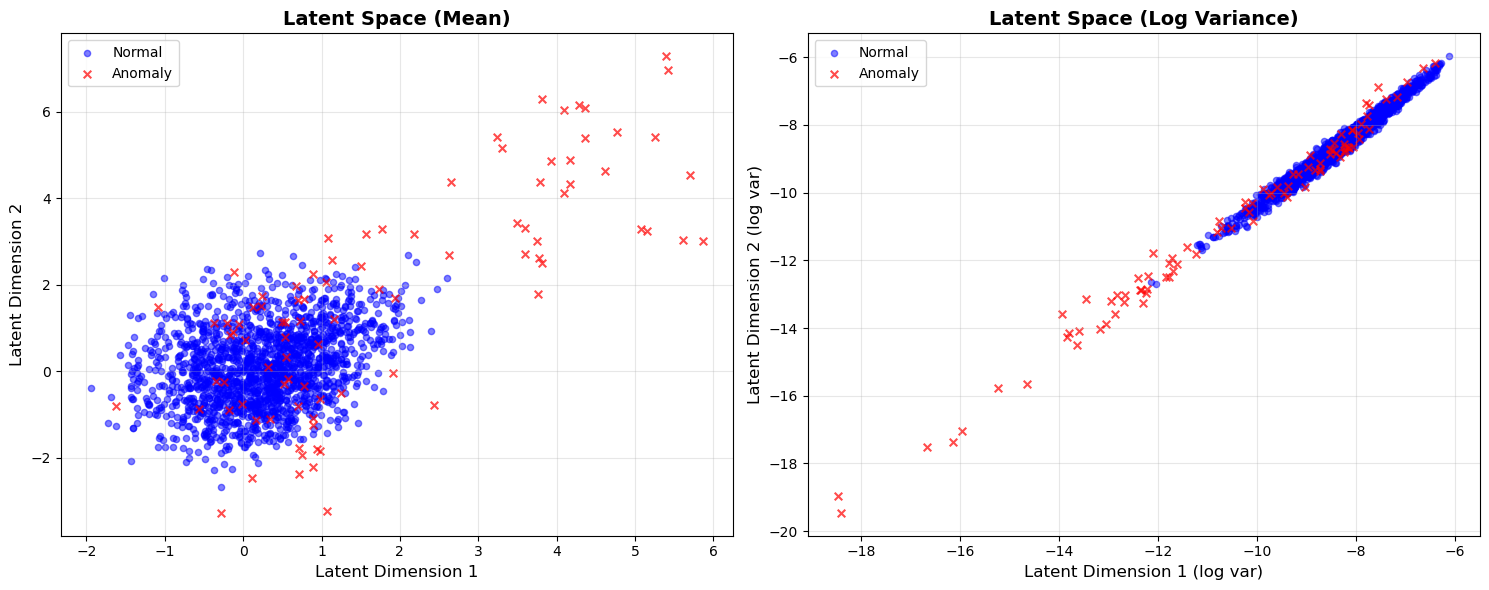

In [10]:
print("\n" + "="*60)
print("STEP 6: GENERATING VISUALIZATIONS")
print("="*60)
    
plot_comprehensive_results(
        vae, history, X_test, y_test, 
        predictions, anomaly_scores, recon_errors, kl_divs
    )
    
plot_latent_space(vae, X_test, y_test)

In [11]:
print("\n" + "="*60)
print("STEP 7: SAVING ARTIFACTS")
print("="*60)
    
    # Save models
vae.model.save('deep_vae_full_model', save_format='tf')


STEP 7: SAVING ARTIFACTS
INFO:tensorflow:Assets written to: deep_vae_full_model\assets


INFO:tensorflow:Assets written to: deep_vae_full_model\assets
